File: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/1999.h5, Dataset Shape: (730, 721, 1440)


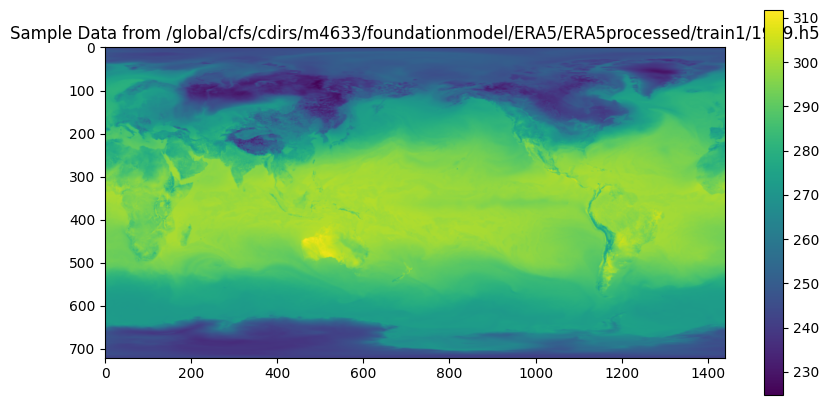

In [1]:
import h5py
import matplotlib.pyplot as plt
import os

# List of HDF5 files
files = ['1999.h5']
folder = '/global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1'

for file in files:
    file = os.path.join(folder, file)
    with h5py.File(file, 'r') as f:
        # Assuming the dataset is named 'data', adjust if necessary
        dataset_name = 'fields'
        
        if dataset_name in f:
            data = f[dataset_name][:, 2, : , :]
            print(f"File: {file}, Dataset Shape: {data.shape}")
            
            # Plotting a sample of the data
            plt.figure(figsize=(10, 5))
            plt.imshow(data[0], cmap='viridis')  # Adjust indexing as needed
            plt.title(f"Sample Data from {file}")
            plt.colorbar()
            plt.show()
        else:
            print(f"Dataset '{dataset_name}' not found in {file}")

In [2]:
import h5py
import os
import numpy as np
from scipy.ndimage import zoom

# Define the directories
input_dirs = [
    "/global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1",
    "/global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train2"
]
output_dir_gt = "/global/cfs/cdirs/m4633/foundationmodel/HATdata/gt"
output_dir_lq = "/global/cfs/cdirs/m4633/foundationmodel/HATdata/lq"
os.makedirs(output_dir_gt, exist_ok=True)
os.makedirs(output_dir_lq, exist_ok=True)

# Define the output file paths
output_file_path_gt = os.path.join(output_dir_gt, 'gt.h5')
output_file_path_lq = os.path.join(output_dir_lq, 'lq.h5')

current_index = 0
def process_file(file_path, gt_file, lq_file, current_idx):
    try:
        with h5py.File(file_path, 'r') as f:
            if 'fields' not in f:
                print(f"Dataset 'fields' not found in {file_path}")
                return False
            
            # Extract channel 2 data
            gt_data = f['fields'][:, 2, :, :]  # Shape will be (730, 721, 1440)
            
            # Create downscaled version (8x smaller) - only scale spatial dimensions
            scale_factor = 1/8
            lq_data = np.zeros((gt_data.shape[0], int(gt_data.shape[1]*scale_factor), int(gt_data.shape[2]*scale_factor)))
            for i in range(gt_data.shape[0]):
                lq_data[i] = zoom(gt_data[i], (scale_factor, scale_factor), order=1)
            
            # For the first file, create the datasets
            if current_idx == 0:
                gt_file.create_dataset('fields', 
                                     shape=gt_data.shape,
                                     maxshape=(None, *gt_data.shape[1:]),
                                     chunks=True,
                                     dtype='float32')
                lq_file.create_dataset('fields', 
                                     shape=lq_data.shape,
                                     maxshape=(None, *lq_data.shape[1:]),
                                     chunks=True,
                                     dtype='float32')
                # Write the first file's data
                gt_file['fields'][:] = gt_data
                lq_file['fields'][:] = lq_data
            else:
                # Get current size and new size
                current_size = gt_file['fields'].shape[0]
                new_size = current_size + gt_data.shape[0]
                
                # Resize datasets
                gt_file['fields'].resize(new_size, axis=0)
                lq_file['fields'].resize(new_size, axis=0)
                
                # Write the new data
                gt_file['fields'][current_size:new_size] = gt_data
                lq_file['fields'][current_size:new_size] = lq_data
            
            print(f"Processed file {current_idx + 1}: {file_path}")
            print(f"Added {gt_data.shape[0]} samples. Current total: {gt_file['fields'].shape[0]}")
            return True
            
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return False

# Open both files in append mode
with h5py.File(output_file_path_gt, 'w') as gt_file, h5py.File(output_file_path_lq, 'w') as lq_file:
    # Traverse the directories and process each .h5 file
    for input_dir in input_dirs:
        for root, _, files in os.walk(input_dir):
            for file in files:
                if file.endswith('.h5'):
                    file_path = os.path.join(root, file)
                    if process_file(file_path, gt_file, lq_file, current_index):
                        current_index += 1
    
    # Print final dataset information
    print(f"\nProcessing complete!")
    print(f"Total number of samples: {current_index}")
    print(f"GT dataset shape: {gt_file['fields'].shape}")
    print(f"LQ dataset shape: {lq_file['fields'].shape}")

Processed file 1: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/1983.h5
Added 730 samples. Current total: 730
Processed file 2: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/1994.h5
Added 730 samples. Current total: 1460
Processed file 3: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/1981.h5
Added 730 samples. Current total: 2190
Processed file 4: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/1992.h5
Added 730 samples. Current total: 2920
Processed file 5: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/1979.h5
Added 730 samples. Current total: 3650
Processed file 6: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/1990.h5
Added 730 samples. Current total: 4380
Processed file 7: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/1988.h5
Added 730 samples. Current total: 5110
Processed file 8: /global/cfs/cdirs/m4633/foundationmodel/ERA5/ERA5processed/train1/

File: /global/cfs/cdirs/m4633/foundationmodel/HATdata/gt/gt.h5, Dataset Shape: (721, 1440)


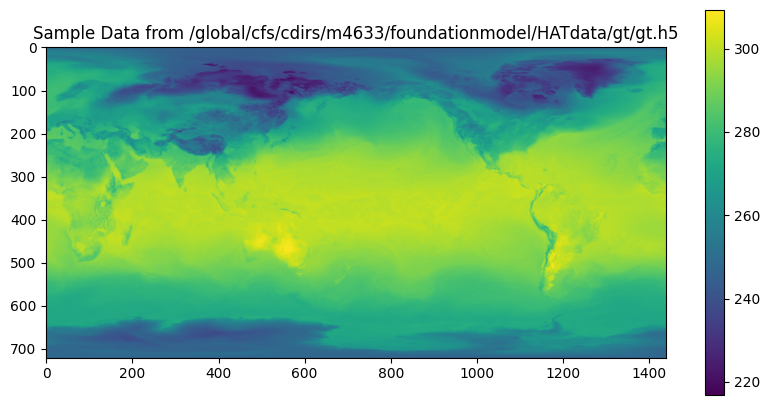

File: /global/cfs/cdirs/m4633/foundationmodel/HATdata/lq/lq.h5, Dataset Shape: (90, 180)


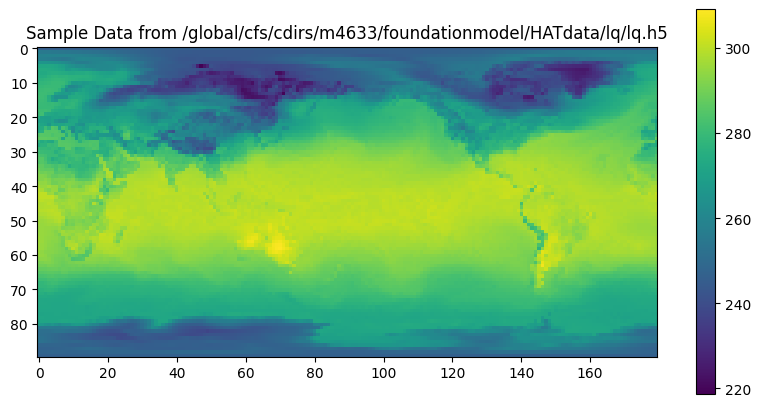

In [4]:
output_dir_gt = "/global/cfs/cdirs/m4633/foundationmodel/HATdata/gt"
output_dir_lq = "/global/cfs/cdirs/m4633/foundationmodel/HATdata/lq"
os.makedirs(output_dir_gt, exist_ok=True)
os.makedirs(output_dir_lq, exist_ok=True)

# Define the output file paths
output_file_path_gt = os.path.join(output_dir_gt, 'gt.h5')
output_file_path_lq = os.path.join(output_dir_lq, 'lq.h5')

for file in [output_file_path_gt, output_file_path_lq]:
    file = os.path.join(folder, file)
    with h5py.File(file, 'r') as f:
        # Assuming the dataset is named 'data', adjust if necessary
        dataset_name = 'fields'
        
        if dataset_name in f:
            data = f[dataset_name][0, : , :]
            print(f"File: {file}, Dataset Shape: {data.shape}")
            
            # Plotting a sample of the data
            plt.figure(figsize=(10, 5))
            plt.imshow(data, cmap='viridis')  # Adjust indexing as needed
            plt.title(f"Sample Data from {file}")
            plt.colorbar()
            plt.show()
        else:
            print(f"Dataset '{dataset_name}' not found in {file}")

In [1]:
import h5py
import numpy as np
import os
import time
from tqdm import tqdm

# Input and output file paths
input_file = "/global/cfs/cdirs/m4633/foundationmodel/HATdata/gt/gt.h5"
output_file = "/global/cfs/cdirs/m4633/foundationmodel/HATdata/gt/gt_rechunked.h5"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Optimal chunk size for 256×256 patch access
chunk_size = (1, 256, 256)

print(f"Starting rechunking process from {input_file} to {output_file}")
print(f"Using optimal chunk size: {chunk_size}")

start_time = time.time()

# Open the original file
with h5py.File(input_file, 'r') as f_in:
    # Get the dataset key (should be 'fields' based on your code)
    dataset_key = 'fields'
    if dataset_key not in f_in:
        # Try to find the first dataset if 'fields' doesn't exist
        dataset_key = list(f_in.keys())[0]
        
    original_data = f_in[dataset_key]
    data_shape = original_data.shape
    data_dtype = original_data.dtype
    
    print(f"Original dataset shape: {data_shape}")
    print(f"Original dataset dtype: {data_dtype}")
    print(f"Original dataset chunks: {original_data.chunks}")
    
    # Calculate total size
    total_size_gb = np.prod(data_shape) * np.dtype(data_dtype).itemsize / (1024**3)
    print(f"Dataset size: {total_size_gb:.2f} GB")
    
    # Create the output file with optimal chunking
    with h5py.File(output_file, 'w') as f_out:
        # Create the dataset with optimal chunking
        dset = f_out.create_dataset(
            dataset_key,
            shape=data_shape,
            dtype=data_dtype,
            chunks=chunk_size,
            compression='gzip',  # Add compression to save space
            compression_opts=4,  # Moderate compression level (1-9, higher = more compression but slower)
            shuffle=True  # Improves compression for floating-point data
        )
        
        # Copy attributes if any
        for attr_name, attr_value in original_data.attrs.items():
            dset.attrs[attr_name] = attr_value
            
        # Copy data in time-slice batches to avoid memory issues
        # Use tqdm for a progress bar
        print(f"Copying data with {data_shape[0]} time steps...")
        
        batch_size = 10  # Process 10 time steps at once to balance memory usage and speed
        for i in range(0, data_shape[0], batch_size):
            # Calculate the end index for this batch
            end_idx = min(i + batch_size, data_shape[0])
            
            # Read a batch of time steps
            batch_data = original_data[i:end_idx, :, :]
            
            # Write to the new file
            dset[i:end_idx, :, :] = batch_data
            
            # Print progress
            progress = end_idx / data_shape[0] * 100
            elapsed = time.time() - start_time
            estimated_total = elapsed / progress * 100
            remaining = estimated_total - elapsed
            
            print(f"Progress: {progress:.1f}% ({end_idx}/{data_shape[0]} time steps) | "
                  f"Elapsed: {elapsed/60:.1f} min | Remaining: {remaining/60:.1f} min")

# Verify the rechunking
with h5py.File(output_file, 'r') as f:
    dset = f[dataset_key]
    print("\nVerification:")
    print(f"New dataset shape: {dset.shape}")
    print(f"New dataset chunks: {dset.chunks}")
    
    # Calculate compression ratio
    compressed_size = os.path.getsize(output_file) / (1024**3)
    print(f"Original size: {total_size_gb:.2f} GB")
    print(f"Compressed size: {compressed_size:.2f} GB")
    print(f"Compression ratio: {total_size_gb/compressed_size:.2f}x")

print(f"\nRechunking completed in {(time.time() - start_time)/60:.1f} minutes")
print(f"New file saved to: {output_file}")

Starting rechunking process from /global/cfs/cdirs/m4633/foundationmodel/HATdata/gt/gt.h5 to /global/cfs/cdirs/m4633/foundationmodel/HATdata/gt/gt_rechunked.h5
Using optimal chunk size: (1, 256, 256)
Original dataset shape: (27010, 721, 1440)
Original dataset dtype: float32
Original dataset chunks: (23, 23, 90)
Dataset size: 104.47 GB
Copying data with 27010 time steps...
Progress: 0.0% (10/27010 time steps) | Elapsed: 0.0 min | Remaining: 66.9 min
Progress: 0.1% (20/27010 time steps) | Elapsed: 0.0 min | Remaining: 53.4 min
Progress: 0.1% (30/27010 time steps) | Elapsed: 0.1 min | Remaining: 51.5 min
Progress: 0.1% (40/27010 time steps) | Elapsed: 0.1 min | Remaining: 48.7 min
Progress: 0.2% (50/27010 time steps) | Elapsed: 0.1 min | Remaining: 49.3 min
Progress: 0.2% (60/27010 time steps) | Elapsed: 0.1 min | Remaining: 48.2 min
Progress: 0.3% (70/27010 time steps) | Elapsed: 0.1 min | Remaining: 48.3 min
Progress: 0.3% (80/27010 time steps) | Elapsed: 0.1 min | Remaining: 47.5 min
P

File: /global/cfs/cdirs/m4633/foundationmodel/HATdata/gt/gt_rechunked.h5, Dataset Shape: (721, 1440), f[dataset_name].shape: (27010, 721, 1440)


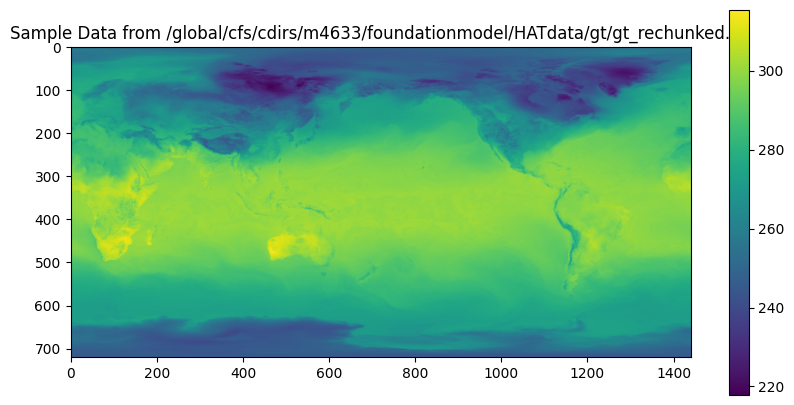

In [3]:
import h5py
import matplotlib.pyplot as plt
import os

# List of HDF5 files
files = ['gt_rechunked.h5']
folder = '/global/cfs/cdirs/m4633/foundationmodel/HATdata/gt'

for file in files:
    file = os.path.join(folder, file)
    with h5py.File(file, 'r') as f:
        # Assuming the dataset is named 'data', adjust if necessary
        dataset_name = 'fields'
        
        if dataset_name in f:
            data = f[dataset_name][5, : , :]
            print(f"File: {file}, Dataset Shape: {data.shape}, f[dataset_name].shape: {f[dataset_name].shape}")
            
            # Plotting a sample of the data
            plt.figure(figsize=(10, 5))
            plt.imshow(data, cmap='viridis')  # Adjust indexing as needed
            plt.title(f"Sample Data from {file}")
            plt.colorbar()
            plt.show()
        else:
            print(f"Dataset '{dataset_name}' not found in {file}")